# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

In [6]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [7]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [8]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [9]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [10]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [11]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [12]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [13]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
        
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [14]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
            
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)

def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
        
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)
    
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        if(ratio_negatives_to_positives >= 1):            
            results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
        else:
            results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    
            
        display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1"]))
        print("")

In [15]:
models ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(), 
    "KNN" : KNeighborsClassifier(weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [16]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 757.3 KB


In [17]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.504228,0.087287,0.529231,0.921091,0.149035
Validation,0.502032,0.084266,0.521836,0.920492,0.144252



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.510865,0.804701,0.507800,0.217091,0.598021
Validation,0.508165,0.783813,0.502262,0.231967,0.586190



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.518365,0.819703,0.515844,0.217091,0.609247
Validation,0.499175,0.796921,0.492200,0.200820,0.588827



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.515683,0.898348,0.508877,0.133091,0.649615
Validation,0.507372,0.881307,0.504254,0.132787,0.640985



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.508273,0.025822,0.745098,0.990636,0.049798
Validation,0.504911,0.022904,0.646667,0.987705,0.044171



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.517411,0.728797,0.522204,0.306091,0.552037
Validation,0.505716,0.726396,0.496605,0.284426,0.542563


In [18]:

comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.531320,0.200399,0.594316,0.862182,0.298773
Validation,0.522891,0.196208,0.556061,0.850000,0.286790



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.539276,0.652092,0.552729,0.426455,0.538314
Validation,0.522108,0.639338,0.527366,0.404918,0.518822



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.545095,0.737611,0.541942,0.352636,0.590124
Validation,0.515176,0.696255,0.506252,0.333607,0.551881



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.547641,0.797246,0.537879,0.298091,0.622839
Validation,0.525385,0.781381,0.514239,0.268852,0.602318



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.513501,0.033551,0.836118,0.993364,0.064425
Validation,0.503684,0.022891,0.488333,0.985246,0.043303



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.536640,0.533521,0.558918,0.539818,0.479054
Validation,0.523727,0.515001,0.541607,0.531967,0.460658


We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [19]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [20]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

,sys,dia,age
5135,195.0,135.0,4
6106,215.0,115.0,4
9058,200.0,120.0,3
11792,190.0,130.0,3
14314,205.0,125.0,4
19137,215.0,117.0,4
20168,190.0,130.0,4
20379,220.0,140.0,4
20582,200.0,118.0,4
28579,180.0,130.0,3


As expected, all pressure variables (including pam) are correlated between each other

In [21]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

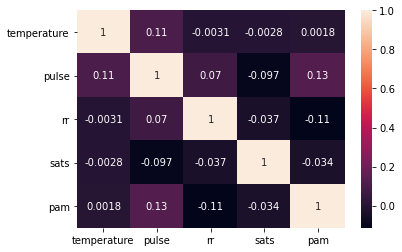

In [22]:
sns.heatmap(vitals.corr(), annot=True)

In [23]:
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.562983,0.529168,0.567384,0.596768,0.547587
Validation,0.566474,0.526864,0.572524,0.606422,0.547010



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.655601,0.619860,0.667651,0.691313,0.642541
Validation,0.574704,0.522302,0.583311,0.627523,0.548526



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998080,0.997573,0.998585,0.998586,0.998078
Validation,0.544091,0.530492,0.548651,0.557798,0.538565



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.575111,0.630169,0.567663,0.520101,0.597037
Validation,0.563743,0.619733,0.557552,0.507339,0.585666



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.997928,0.995855,1.00000,1.000000,0.997923
Validation,0.543630,0.531418,0.54612,0.555963,0.537184



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.586680,0.554645,0.592393,0.618687,0.572890
Validation,0.582948,0.550575,0.586237,0.615596,0.565538


In [24]:
vitals_ex = pd.merge(vitals, e_factors, left_index=True, right_index=True)
run_models(vitals_ex, y[vitals_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.573696,0.542313,0.578402,0.605051,0.559727
Validation,0.569666,0.533211,0.575941,0.606422,0.553311



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.659441,0.628247,0.669873,0.690606,0.648348
Validation,0.598002,0.567832,0.602624,0.628440,0.582072



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999646,0.999596,0.999697,0.999697,0.999646
Validation,0.564647,0.560567,0.567565,0.568807,0.562189



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.573695,0.591548,0.570819,0.555859,0.580534
Validation,0.562369,0.589691,0.558570,0.534862,0.572903



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999747,0.999495,1.000000,1.000000,0.999747
Validation,0.543178,0.528699,0.546233,0.557798,0.536973



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.590673,0.565767,0.595262,0.615556,0.580069
Validation,0.596624,0.557790,0.603905,0.635780,0.577561


In [25]:
vitals_comorb = pd.merge(vitals, comorb, left_index=True, right_index=True)
run_models(vitals_comorb, y[vitals_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570562,0.537863,0.575336,0.603232,0.555939
Validation,0.574234,0.531384,0.582894,0.617431,0.555020



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.639988,0.595188,0.654060,0.684747,0.622748
Validation,0.576061,0.535063,0.581164,0.617431,0.553591



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998434,0.998382,0.998484,0.998485,0.998433
Validation,0.564654,0.561435,0.566889,0.567890,0.563764



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.567278,0.549384,0.569853,0.585152,0.558997
Validation,0.565119,0.546038,0.567241,0.584404,0.554894



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998939,0.998079,0.999797,0.999798,0.998937
Validation,0.515764,0.533269,0.515641,0.498165,0.523716



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.582638,0.557678,0.586806,0.607576,0.571826
Validation,0.570590,0.536864,0.574427,0.604587,0.553329


In [26]:
vitals_comorb_ex = pd.merge(vitals_comorb, e_factors, left_index=True, right_index=True)
run_models(vitals_comorb_ex, y[vitals_comorb_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572836,0.540490,0.577785,0.605152,0.558449
Validation,0.567389,0.525046,0.573416,0.610092,0.547207



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.653125,0.625013,0.662378,0.681212,0.642894
Validation,0.587034,0.565088,0.591795,0.609174,0.576217



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999747,0.999697,0.999798,0.999798,0.999747
Validation,0.561895,0.565071,0.564203,0.558716,0.564134



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.571270,0.546460,0.574589,0.596061,0.559854
Validation,0.583377,0.543228,0.591240,0.623853,0.565149



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999848,0.999697,1.000000,1.000000,0.999848
Validation,0.550480,0.534112,0.553153,0.566972,0.542959



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.590672,0.566777,0.595006,0.614545,0.580532
Validation,0.592047,0.567731,0.595846,0.616514,0.580094


### Assesed Symptoms

In [27]:
a_symptoms.dropna(how="all", inplace=True)

In [28]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.545467,0.848746,0.528288,0.242272,0.651219
Validation,0.533752,0.848144,0.520756,0.218487,0.645080



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.591564,0.403000,0.647288,0.780074,0.496645
Validation,0.581655,0.399846,0.631169,0.763866,0.487293



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.605205,0.400111,0.678227,0.810242,0.503241
Validation,0.585837,0.373929,0.651163,0.798319,0.473135



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.545187,0.439398,0.608175,0.650931,0.419057
Validation,0.531240,0.419181,0.569918,0.643697,0.401830



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.589420,0.325874,0.694134,0.852886,0.436372
Validation,0.574067,0.295938,0.646539,0.852941,0.396434



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.537738,0.833288,0.523737,0.242272,0.643106
Validation,0.547184,0.828901,0.530340,0.264706,0.646493


In [29]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.551008,0.766424,0.535821,0.335661,0.629585
Validation,0.549235,0.744055,0.534155,0.353782,0.619351



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.601062,0.535631,0.618979,0.666480,0.570324
Validation,0.592142,0.503739,0.620086,0.680672,0.549621



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.647251,0.548753,0.685918,0.745717,0.607174
Validation,0.552674,0.419972,0.571529,0.685714,0.481259



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572566,0.609404,0.575661,0.535754,0.577209
Validation,0.554325,0.584916,0.557389,0.523529,0.553050



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.622200,0.349533,0.770151,0.894786,0.479849
Validation,0.558968,0.287535,0.630910,0.831092,0.393983



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.564650,0.691347,0.551549,0.437989,0.611192
Validation,0.561454,0.678901,0.551126,0.443697,0.604318


In [30]:
a_symptoms_comorb = pd.merge(a_symptoms, comorb, left_index=True, right_index=True)
run_models(a_symptoms_comorb, y[a_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.548074,0.822483,0.531051,0.273743,0.645302
Validation,0.537520,0.808711,0.524382,0.265546,0.635820



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.591889,0.423024,0.639587,0.760708,0.508454
Validation,0.587507,0.418291,0.633570,0.757143,0.501025



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.625507,0.455992,0.691067,0.794972,0.548646
Validation,0.581223,0.409916,0.626583,0.752941,0.492098



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.552543,0.550516,0.595712,0.554655,0.502630
Validation,0.544244,0.538123,0.560856,0.549580,0.484166



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.604415,0.343024,0.721273,0.865736,0.461963
Validation,0.571538,0.306744,0.639300,0.836975,0.409703



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.548633,0.774893,0.533486,0.322439,0.631710
Validation,0.542159,0.755910,0.529098,0.327731,0.621537


In [31]:
a_symptoms_comorb_ef = pd.merge(a_symptoms, comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef, y[a_symptoms_comorb_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.555570,0.692908,0.543042,0.418250,0.592518
Validation,0.535857,0.661457,0.529658,0.410084,0.569410



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.599338,0.529393,0.624239,0.669274,0.563364
Validation,0.574500,0.487822,0.603017,0.661345,0.527637



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.639195,0.489243,0.699453,0.789106,0.575400
Validation,0.579113,0.412409,0.620875,0.746218,0.493995



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.567724,0.591832,0.584389,0.543669,0.554372
Validation,0.540895,0.551884,0.539100,0.529412,0.516805



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.618710,0.337720,0.773070,0.899628,0.467978
Validation,0.551839,0.277367,0.615837,0.826891,0.378040



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.575359,0.745548,0.556176,0.405214,0.637012
Validation,0.568183,0.732535,0.551165,0.403361,0.628665


In [32]:
a_symptoms_comorb_ef_vitals = pd.merge(vitals, a_symptoms_comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef_vitals, y[a_symptoms_comorb_ef_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.583819,0.626691,0.577508,0.540974,0.600585
Validation,0.580292,0.603536,0.577663,0.556881,0.588747



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.669186,0.642309,0.678794,0.696045,0.659870
Validation,0.622848,0.587056,0.631420,0.658716,0.606598



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999696,0.999797,0.999595,0.999594,0.999696
Validation,0.586218,0.566005,0.591610,0.606422,0.577402



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.573370,0.564993,0.574588,0.581744,0.569339
Validation,0.573908,0.554270,0.577955,0.593578,0.564264



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999543,0.999087,1.000000,1.000000,0.999543
Validation,0.529056,0.514103,0.530687,0.544037,0.521277



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.607354,0.601116,0.608693,0.61359,0.604848
Validation,0.581149,0.594270,0.578531,0.56789,0.584683


### Reported symptoms

In [33]:
r_symptoms

,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,True,3.0,NaN,False,0.0,False,False,False,False,False,False,False,False
1,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
2,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2.0,False,True,2.0,False,True,False,False,False,False,False,True
4,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False
93990,True,2.0,False,False,0.0,False,False,False,False,False,True,False,True
93991,False,0.0,True,False,0.0,False,False,False,False,False,False,False,False
93993,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False


In [34]:
r_symptoms.dropna(how="all", inplace=True)

In [35]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.626829,0.360066,0.772196,0.893545,0.490822
Validation,0.618720,0.355051,0.747385,0.882787,0.477493



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.660287,0.496000,0.739040,0.824545,0.593362
Validation,0.660905,0.488451,0.740305,0.833607,0.585188



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.702427,0.501090,0.839034,0.903727,0.627246
Validation,0.639202,0.439344,0.729820,0.839344,0.545619



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.679152,0.501455,0.778383,0.856818,0.609682
Validation,0.656410,0.472898,0.744198,0.840164,0.574272



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.695245,0.447538,0.888087,0.942909,0.594411
Validation,0.637153,0.389391,0.768016,0.885246,0.511548



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.665788,0.486089,0.759212,0.845455,0.592472
Validation,0.656845,0.476183,0.747114,0.837705,0.576609


In [36]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.621965,0.332606,0.789743,0.911273,0.467601
Validation,0.619533,0.329628,0.780239,0.909836,0.460036



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.658605,0.499908,0.732442,0.817273,0.594099
Validation,0.660514,0.492563,0.737100,0.828689,0.587299



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.702700,0.499817,0.841448,0.905545,0.626844
Validation,0.646173,0.441850,0.743659,0.850820,0.552362



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.685971,0.497724,0.798825,0.874182,0.612940
Validation,0.650676,0.471291,0.730687,0.830328,0.571476



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.699018,0.456448,0.887394,0.941545,0.602395
Validation,0.637171,0.400873,0.758451,0.873770,0.520200



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662151,0.482813,0.752693,0.841455,0.588224
Validation,0.654761,0.479448,0.737662,0.830328,0.576410


In [37]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.617646,0.325965,0.782359,0.909273,0.459572
Validation,0.614225,0.329715,0.762591,0.899180,0.458947



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.659287,0.501545,0.732950,0.817000,0.595384
Validation,0.656835,0.496655,0.729289,0.817213,0.586578



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.697563,0.499907,0.826860,0.895182,0.622877
Validation,0.641669,0.440197,0.736136,0.843443,0.548879



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.685016,0.503634,0.790450,0.866364,0.615079
Validation,0.651905,0.469665,0.735222,0.834426,0.571266



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.686244,0.432717,0.880625,0.939727,0.578275
Validation,0.634302,0.376343,0.779093,0.892623,0.503238



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.663834,0.491181,0.752969,0.836455,0.593336
Validation,0.661322,0.488491,0.750419,0.834426,0.584768


In [38]:
ra_symptoms = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms, left_index=True, right_index=True)
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.640778,0.498650,0.696690,0.782868,0.581174
Validation,0.636597,0.492976,0.689104,0.780672,0.572241



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.670019,0.531993,0.734833,0.808007,0.617146
Validation,0.658410,0.524748,0.713573,0.792437,0.600344



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.761792,0.588806,0.900219,0.934730,0.711875
Validation,0.648339,0.477829,0.724348,0.819328,0.573516



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.659077,0.461678,0.762952,0.856425,0.575053
Validation,0.641191,0.447556,0.723480,0.835294,0.549288



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.755366,0.546990,0.938094,0.963687,0.690661
Validation,0.628629,0.417465,0.723259,0.840336,0.526461



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.668436,0.523151,0.739633,0.813687,0.611506
Validation,0.651719,0.507934,0.712664,0.795798,0.589395


In [39]:
r_symptoms_ex = pd.merge(r_symptoms.drop(columns=["sob", "cough"]), e_factors, left_index=True, right_index=True)
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.643149,0.471724,0.717940,0.814545,0.569265
Validation,0.629399,0.464827,0.689359,0.794262,0.552552



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.66356,0.514184,0.733845,0.812909,0.604437
Validation,0.64905,0.505664,0.705006,0.792623,0.585953



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.747795,0.568197,0.887582,0.927364,0.692460
Validation,0.628998,0.449180,0.704189,0.809016,0.545957



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.671288,0.485724,0.772340,0.856818,0.596341
Validation,0.652713,0.470452,0.739878,0.835246,0.571318



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.748477,0.540186,0.931907,0.956727,0.681978
Validation,0.627308,0.399240,0.733672,0.855738,0.514276



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661515,0.493366,0.743816,0.829636,0.592988
Validation,0.656010,0.476216,0.742916,0.836066,0.577332


In [40]:
r_symptoms_vitals = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), vitals, left_index=True, right_index=True)
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.660048,0.519261,0.722685,0.800707,0.604209
Validation,0.656022,0.517781,0.716265,0.795413,0.598500



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.693144,0.591449,0.742327,0.794747,0.658223
Validation,0.661045,0.563236,0.700462,0.759633,0.622422



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999242,0.999292,0.999192,0.999192,0.999242
Validation,0.629980,0.598741,0.640923,0.661468,0.618051



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.576878,0.557278,0.580405,0.596465,0.567939
Validation,0.576972,0.547773,0.582476,0.606422,0.562169



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999747,0.999494,1.000000,1.000000,0.999747
Validation,0.533568,0.459558,0.542376,0.608257,0.496741



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.672781,0.553739,0.726709,0.791717,0.628391
Validation,0.655553,0.536847,0.705859,0.775229,0.607443


In [41]:
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.660816,0.528054,0.718800,0.793509,0.608760
Validation,0.647595,0.523319,0.695669,0.772477,0.594419



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.693076,0.604972,0.734596,0.781136,0.663262
Validation,0.666350,0.572535,0.707193,0.760550,0.629333



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999848,0.999696,1.000000,1.000000,0.999848
Validation,0.617865,0.584495,0.626954,0.651376,0.604509



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.578037,0.552007,0.582228,0.604057,0.566479
Validation,0.569733,0.542377,0.573487,0.597248,0.556611



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999848,0.999696,1.000000,1.00000,0.999848
Validation,0.546429,0.464821,0.557697,0.62844,0.505825



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.675627,0.559001,0.729233,0.792191,0.632649
Validation,0.663171,0.537898,0.719078,0.788991,0.611868


In [42]:
r_symptoms_comorb = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), comorb, left_index=True, right_index=True)
run_models(r_symptoms_comorb, y[r_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.641103,0.418347,0.754451,0.863818,0.538133
Validation,0.635125,0.410702,0.745401,0.859836,0.526675



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661879,0.511821,0.731434,0.811909,0.602140
Validation,0.649040,0.508110,0.703373,0.790164,0.587157



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.717292,0.525095,0.853315,0.909455,0.649961
Validation,0.643309,0.445895,0.734846,0.840984,0.552799



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.698154,0.515821,0.812107,0.880455,0.630687
Validation,0.645358,0.477063,0.717162,0.813934,0.570696



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.708246,0.467172,0.903180,0.949273,0.615048
Validation,0.631042,0.383786,0.758327,0.878689,0.508443



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.664287,0.488905,0.752916,0.839636,0.592788
Validation,0.653535,0.482727,0.730769,0.824590,0.578113


In [43]:
all_data = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms_comorb_ef_vitals, left_index=True, right_index=True)
run_models(all_data, y[all_data.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.666244,0.537999,0.723647,0.794422,0.617046
Validation,0.649418,0.523311,0.701177,0.776147,0.596296



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.692923,0.600304,0.737065,0.785497,0.661511
Validation,0.669111,0.575296,0.710253,0.763303,0.634155



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999797,0.999594,1.000000,1.000000,0.999797
Validation,0.621072,0.600017,0.628991,0.642202,0.613402



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.580422,0.558196,0.584008,0.602637,0.570591
Validation,0.575263,0.556097,0.578603,0.594495,0.565473



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999899,0.999797,1.000000,1.000000,0.999898
Validation,0.545564,0.477740,0.551829,0.613761,0.511335



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.679027,0.580822,0.722775,0.777181,0.644017
Validation,0.664044,0.549733,0.714585,0.778899,0.619753


In [44]:
a = pd.Series(np.array([True, False, True, False]))
b = pd.Series(np.array([True, True, False, False]))

In [45]:
(a ^ b)

0    False
1     True
2     True
3    False
dtype: bool

Next step is to determine which features are useful in the case of each dataset, eliminating them one by one(and maybe applying normalization to the vitals).
After that, we select the 2 (first just 2) best models and somehow combine them to make an ensemble model.<br>
<i>Idea: One model for each metric so 4 models with the highest metrics and then figure out some boolean operation to combine them</i><br>
<i>Idea 2: The boolean operation can be found by using a Decision Tree. After all they are good at finding simple rules</i><br>
<i>Idea 3: The boolean operation taking the highest precision and the highest recall would be an AND. Maybe the inverse for another 2 metrics as well</i>

In [46]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [47]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.672288,0.515917,0.751747,0.828636,0.611213
Validation,0.660095,0.493376,0.738209,0.827049,0.589656


In [48]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [49]:
ensemble_models = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "Logisctic"
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



In [50]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], {"Ada" : AdaBoostClassifier(base_estimator=LogisticRegression())}, folds=10, ratio_negatives_to_positives=1)

Ada
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.680396,0.584271,0.723223,0.776471,0.646282
Validation,0.662214,0.576205,0.696585,0.748624,0.629128


In [51]:
run_models(X.drop(columns=["sys", "dia"]), y, ensemble_models, ratio_negatives_to_positives=1)

LogisticVanilla
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.678061,0.581012,0.721063,0.775091,0.643426
Validation,0.645775,0.545795,0.681867,0.745902,0.604514



LogisticStrongRegularization
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.672879,0.577923,0.713400,0.767818,0.638530
Validation,0.666224,0.554725,0.713006,0.777869,0.622303



LogisticWeakRegularization
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.672515,0.569830,0.717298,0.775182,0.634886
Validation,0.661720,0.557943,0.703120,0.765574,0.620591



LogiscticAdaBoost
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.678652,0.586105,0.719247,0.771182,0.645788
Validation,0.663364,0.566993,0.700625,0.759836,0.625070


In [52]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

In [53]:
run_models(X.drop(columns=["sys", "dia"]), y, ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.684789,0.592466,0.726809,0.777091,0.652474
Validation,0.659262,0.564521,0.697459,0.754098,0.621095



Ada Logistic
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.679879,0.587558,0.720747,0.772182,0.647257
Validation,0.672765,0.573551,0.714250,0.772131,0.634661



Ada algo
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.676243,0.595736,0.712648,0.756727,0.646985
Validation,0.664180,0.558850,0.708283,0.769672,0.621779



Ada learning rate
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.688335,0.582558,0.739083,0.794091,0.651158
Validation,0.652293,0.543263,0.695774,0.761475,0.607342



Ada complete
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.664560,0.618654,0.681436,0.710455,0.648323
Validation,0.657645,0.607144,0.674993,0.708197,0.637458


In [54]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.695613,0.597766,0.743521,0.793408,0.662473
Validation,0.657184,0.550617,0.701922,0.764220,0.615362



Ada Logistic
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.678468,0.587620,0.718010,0.769270,0.646168
Validation,0.668650,0.580792,0.706636,0.756881,0.636308



Ada algo
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.683439,0.586705,0.728132,0.780122,0.649003
Validation,0.664484,0.567890,0.703697,0.761468,0.626032



Ada learning rate
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.694293,0.570573,0.758198,0.817951,0.651047
Validation,0.673663,0.551510,0.729763,0.796330,0.626747



Ada complete
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.665077,0.627700,0.678646,0.702434,0.651852
Validation,0.664503,0.629124,0.679534,0.700000,0.652208


## Sidequest: Understanding logistic regression

In [55]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(ra_symptoms_vitals, y[ra_symptoms_vitals.index])
lr.fit(ra_symptoms_vitals, y[ra_symptoms_vitals.index], sample_weight=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative")))

LogisticRegression()

In [108]:
lr_preds = lr.predict(ra_symptoms_vitals)

In [64]:
manual_preds = np.dot(ra_symptoms_vitals, lr.coef_.transpose()) + lr.intercept_ #The dot product of coeficients and features plus the bias

In [73]:
from math import exp
def logistic_function(value):
    return 1 / (1 + exp(-value))

In [80]:
manual_preds.flatten()

array([-3.949284909167561, -3.424225587900513, -4.916131014600608, ...,
       -4.491917668894993, -5.356304480985084, -4.790966803253636],
      dtype=object)

In [84]:
lfv = np.vectorize(logistic_function) #To vectorize means to apply it to vectors

In [142]:
result = pd.Series(lfv(manual_preds).flatten())
result[result > .5] = "Positive"
result[result != "Positive"] = "Negative"

In [174]:
a = np.array([[1,2,3,4,5],[2,4,6,8,10]])
b = np.ones((5,2))
b[:,1] *= 2

In [175]:
np.dot(a, b)

array([[15., 30.],
       [30., 60.]])